In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import plotly.figure_factory as ff
from textblob import TextBlob
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
# Load the data
path = 'Combined Data.csv'
df = pd.read_csv(path)

# Display the first few rows of the dataframe
print(df.head())

# EDA
print("Dataset Info:")
print(df.info())

print("Missing Values:")
print(df.isnull().sum())


   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB
None
Missing Values:
Unnamed: 0      0
statement     362
status          0
dtype: int64


In [3]:
# Distribution of target labels
fig = px.histogram(df, x='status', title='Distribution of Mental Health Status')
fig.show()

# Handle NaN values in the statement column
df['statement'] = df['statement'].fillna('')



In [4]:
# Calculate text lengths
df['text_length'] = df['statement'].apply(lambda x: len(str(x).split()))

# Create the histogram
fig = px.histogram(df, x='text_length', title='Text Length Distribution', nbins=50, template='plotly_dark')

# Calculate mean and median
mean_text_length = df['text_length'].mean()
median_text_length = df['text_length'].median()

# Add mean and median lines
fig.add_vline(x=mean_text_length, line_dash="dash", line_color="green", annotation_text="Mean", annotation_position="top left")
fig.add_vline(x=median_text_length, line_dash="dash", line_color="red", annotation_text="Median", annotation_position="top right")

# Update layout for better visualization
fig.update_layout(
    xaxis_title='Text Length (Number of Words)',
    yaxis_title='Count',
    title_x=0.5,
    bargap=0.2,
    annotations=[
        dict(
            x=mean_text_length,
            y=max(df['text_length']),
            xref='x',
            yref='y',
            text='Mean',
            showarrow=True,
            arrowhead=2,
            ax=20,
            ay=-30
        ),
        dict(
            x=median_text_length,
            y=max(df['text_length']),
            xref='x',
            yref='y',
            text='Median',
            showarrow=True,
            arrowhead=2,
            ax=-20,
            ay=-30
        )
    ]
)

# Show the figure
fig.show()


In [5]:
# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    return text

df['cleaned_statement'] = df['statement'].apply(lambda x: preprocess_text(x))

# Tokenization and Stopwords Removal
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned_statement'] = df['cleaned_statement'].apply(lambda x: remove_stopwords(x))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
# Splitting the data
X = df['cleaned_statement']
y = df['status']

# Tokenization
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=100)

# Convert labels to integers
label_map = {label: idx for idx, label in enumerate(y.unique())}
y_int = y.map(label_map)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_int, test_size=0.2, random_state=42)


In [8]:
# Build the CNN model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128))  # Removed input_length
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(label_map), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)


Epoch 1/10
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 69s 60ms/step - accuracy: 0.5814 - loss: 1.1353 - val_accuracy: 0.7410 - val_loss: 0.6650
Epoch 2/10
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 85s 64ms/step - accuracy: 0.7761 - loss: 0.5910 - val_accuracy: 0.7508 - val_loss: 0.6424
Epoch 3/10
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 66s 62ms/step - accuracy: 0.8496 - loss: 0.4084 - val_accuracy: 0.7552 - val_loss: 0.6793
Epoch 4/10
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 85s 65ms/step - accuracy: 0.9137 - loss: 0.2560 - val_accuracy: 0.7486 - val_loss: 0.7904
Epoch 5/10
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 78s 61ms/step - accuracy: 0.9490 - loss: 0.1557 - val_accuracy: 0.7414 - val_loss: 0.9564
Epoch 6/10
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 85s 64ms/step - accuracy: 0.9701 - loss: 0.0987 - val_accuracy: 0.7387 - val_loss: 1.1128
Epoch 7/10
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 79s 62ms/step - accuracy: 0.9788 - loss: 0.0752 - val_accuracy: 0.7420 - val_loss: 1.2055
Epoch 8/10
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 85s 65ms/step - accuracy: 0.9813 -

In [9]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluation
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred_classes))

print("Classification Report:")
print(classification_report(y_test, y_pred_classes))



332/332 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7391 - loss: 1.5553
Test Accuracy: 0.7360731363296509
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Accuracy Score:
0.7360731454425488
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.74      0.78       779
           1       0.88      0.90      0.89      3327
           2       0.69      0.66      0.67      3100
           3       0.56      0.68      0.61      2018
           4       0.63      0.51      0.57       557
           5       0.86      0.70      0.77       580
           6       0.71      0.50      0.59       248

    accuracy                           0.74     10609
   macro avg       0.74      0.67      0.70     10609
weighted avg       0.74      0.74      0.74     10609



In [10]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
cm_fig = ff.create_annotated_heatmap(
    z=cm,
    x=list(label_map.keys()),
    y=list(label_map.keys()),
    annotation_text=cm,
    colorscale='Viridis'
)
cm_fig.update_layout(title='Confusion Matrix')
cm_fig.show()


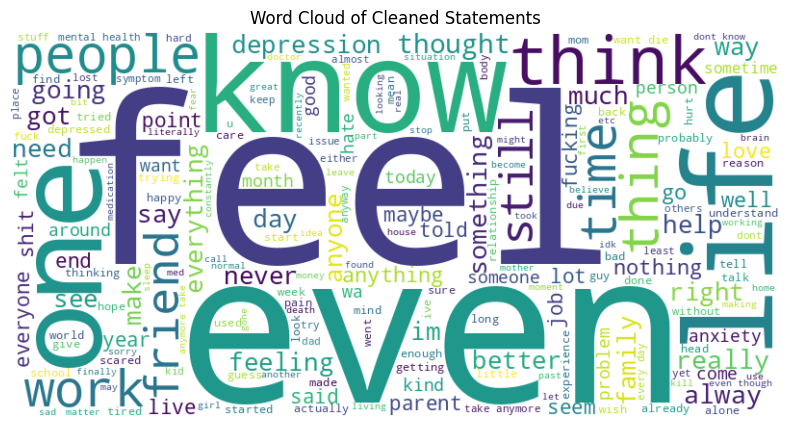

In [11]:
# Word Cloud
all_text = ' '.join(df['cleaned_statement'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Statements')
plt.show()




In [12]:
# Status Distribution
fig = px.pie(df, names='status', title='Proportion of Each Status Category')
fig.show()

In [13]:
def predict_status(statement, tokenizer, model, label_map, reverse_label_map):
    # Preprocess the input statement
    processed_statement = preprocess_text(statement)
    processed_statement = remove_stopwords(processed_statement)

    # Tokenize and pad the statement
    sequence = tokenizer.texts_to_sequences([processed_statement])
    padded_sequence = pad_sequences(sequence, maxlen=100)

    # Predict the status
    prediction = model.predict(padded_sequence)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Map the predicted class to the status label
    predicted_status = reverse_label_map[predicted_class]

    return predicted_status

# Create reverse label map for decoding
reverse_label_map = {idx: label for label, idx in label_map.items()}

# Example usage:
statement_to_predict = 'trouble sleeping, confused mind, restless heart. All out of tune'
predicted_status = predict_status(statement_to_predict, tokenizer, model, label_map, reverse_label_map)
print(f"The predicted status for the given statement is: {predicted_status}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
The predicted status for the given statement is: Anxiety


In [14]:
# Example usage:
statement_to_predict = 'I have nothing left. I do not want to be here anymore, I want to be free, I want to go. I received no help from my psychiatrist nor from my doctor when I told them about my depression because I am 16 in the middle of a global pandemic so they think I am just sad like everyone else. I am tired of receiving no help whatsoever. I needed it but now, it is too late. I just want to die already. I have had anxiety for my whole life and was diagnosed with it 3 years ago. But now, the consequences are too important. I just want some rest god dammit. My parents do not care, they do not want to help me and my friends are mean to me for no reason.'
predicted_status = predict_status(statement_to_predict, tokenizer, model, label_map, reverse_label_map)
print(f"The predicted status for the given statement is: {predicted_status}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
The predicted status for the given statement is: Depression
